In [1]:
!pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("cleandat4modelling.csv")

In [3]:
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from tabulate import tabulate
from tqdm import tqdm

In [4]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [5]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

In [6]:
mean_weight = round(data.weight.mean())
data.weight = data.weight.fillna(mean_weight)
data = data.replace([np.inf, -np.inf], 0)

In [7]:
data.isna().sum()

id                                  0
encounter_id                        0
patient_nbr                         0
race                                0
gender                              0
                                   ..
time_in_hospital_per_procedure      0
number_medications_per_diagnosis    0
average_lab_procedure_cost          0
emergency_room_visit_rate           0
inpatient_admission_rate            0
Length: 64, dtype: int64

In [16]:
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate

def BasedLine(df, method, models, n_splits=10):
    start_time = time.time()  # Record the start time

    df_check = df.copy()


    y = df_check['readmitted']
    X = df_check.drop(columns='readmitted')

    #X = X.fillna(0)
    X = X.fillna(X.mean())
    # Define the cross-validation strategy (Stratified K-Fold)
    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=2023, shuffle=True)

    # Test options and evaluation metric
    scoring = 'accuracy'
    results, results_weigh = [], []
    names = []
    scores, scores_weigh = [], []
    auc_scores = []  # Store AUC scores
    data = []

    for name, model in models:
        model_scores = []
        model_scores_weigh = []
        model_auc_scores = []  # Store AUC scores for each fold

        with tqdm(total=n_splits, desc=f"Running {name}") as pbar:
            for train_idx, test_idx in stratified_kfold.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

                #smote analysis
                smote = SMOTE(random_state=42)
                X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
                model.fit(X_train_resampled, y_train_resampled)

                score_non = f1_score(model.predict(X_valid), y_valid)
                score_weigh = f1_score(model.predict(X_valid), y_valid, average='weighted')
                model_scores.append(score_non)
                model_scores_weigh.append(score_weigh)

                # Calculate AUC score
                proba = model.predict_proba(X_valid)[:, 1]
                auc = roc_auc_score(y_valid, proba)
                model_auc_scores.append(auc)

                pbar.update(1)

        names.append(name)
        scores_weigh.append(model_scores_weigh)
        auc_scores.append(model_auc_scores)  # Store AUC scores for the model

        # Calculate mean AUC score across folds
        mean_auc = np.mean(model_auc_scores)

        data.append([name, np.mean(model_scores), np.mean(model_scores_weigh), mean_auc])

    headers = ["Model", "F1 Score", "F1 Score Weighted", "AUC Score"]
    print(tabulate(data, headers=headers, tablefmt='orgtbl'))

    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(execution_time))

    df_results = pd.DataFrame(data, columns=headers)
    return df_results



In [17]:
def BasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    basedModels.append(('ET'   , ExtraTreesClassifier()))
    return basedModels

In [18]:
models = BasedModel()

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)




In [20]:
#result
result = BasedLine(df = data, method = False , models = models, n_splits=10)

Running ET: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [24:54<00:00, 149.42s/it]

| Model   |   F1 Score |   F1 Score Weighted |   AUC Score |
|---------+------------+---------------------+-------------|
| LR      |  0.18151   |            0.501461 |    0.514318 |
| RF      |  0.0473871 |            0.933149 |    0.630065 |
| ET      |  0.0535588 |            0.930261 |    0.621224 |
Execution time: 2849.28 seconds


In [21]:
result

Model  F1 Score  F1 Score Weighted  AUC Score
0    LR  0.181510           0.501461   0.514318
1    RF  0.047387           0.933149   0.630065
2    ET  0.053559           0.930261   0.621224

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for color palettes

def plot_bar_and_histogram(dataframe):
    plt.figure(figsize=(15, 5))

    # Define a color palette with the number of unique models in the DataFrame
    num_models = len(dataframe['Model'])
    colors = sns.color_palette('husl', n_colors=num_models)

    # Bar plot for F1 Score
    ax1 = plt.subplot(1, 3, 1)
    bars = plt.bar(dataframe['Model'], dataframe['F1 Score'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('Plot of F1 Score')

    # Add text annotations to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

    # Bar plot for F1 Score Weighted
    plt.subplot(1, 3, 2)
    barss = plt.bar(dataframe['Model'], dataframe['F1 Score Weighted'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('F1 Score Weighted')
    plt.title('Plot of F1 Score Weighted')

    # Add text annotations to the bars
    for bar in barss:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')
        
    # Bar plot for AUC Score
    plt.subplot(1, 3, 3)
    barss = plt.bar(dataframe['Model'], dataframe['AUC Score'], color=colors)
    plt.xlabel('Model')
    plt.ylabel('AUC Score')
    plt.title('Plot of AUC Score')

    # Add text annotations to the bars
    for bar in barss:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


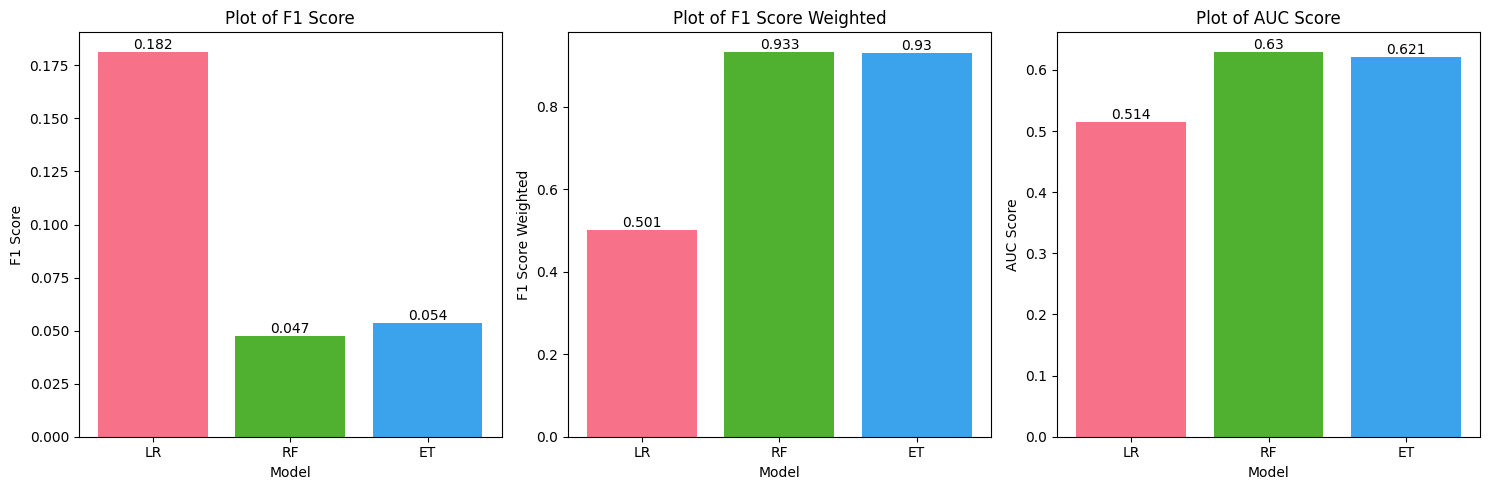

In [23]:
plot_bar_and_histogram(dataframe = result)

In [24]:
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate

def BasedLine(df, method, models, n_splits=10):
    start_time = time.time()  # Record the start time

    df_check = df.copy()

    y = df_check['readmitted']
    X = df_check.drop(columns='readmitted')

    #X = X.fillna(0)
    X = X.fillna(X.mean())
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)

    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=2023, shuffle=True)

    scoring = 'accuracy'
    results, results_weigh = [], []
    names = []
    scores, scores_weigh = [], []
    auc_scores = []  # Store AUC scores
    data = []
    for name, model in models:
        model_scores = []
        model_scores_weigh = []
        model_auc_scores = []  # Store AUC scores for each fold

        with tqdm(total=n_splits, desc=f"Running {name}") as pbar:
            for train_idx, test_idx in stratified_kfold.split(X, y):
                X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                score_non = f1_score(model.predict(X_valid), y_valid)
                score_weigh = f1_score(model.predict(X_valid), y_valid, average='weighted')
                model_scores.append(score_non)
                model_scores_weigh.append(score_weigh)

                # Calculate AUC score
                proba = model.predict_proba(X_valid)[:, 1]
                auc = roc_auc_score(y_valid, proba)
                model_auc_scores.append(auc)

                pbar.update(1)

        names.append(name)
        scores_weigh.append(model_scores_weigh)
        auc_scores.append(model_auc_scores)  # Store AUC scores for the model

        # Calculate mean AUC score across folds
        mean_auc = np.mean(model_auc_scores)

        data.append([name, np.mean(model_scores), np.mean(model_scores_weigh), mean_auc])

    headers = ["Model", "F1 Score", "F1 Score Weighted", "AUC Score"]
    print(tabulate(data, headers=headers, tablefmt='orgtbl'))

    end_time = time.time()  # Record the end time
    execution_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(execution_time))

    df_results = pd.DataFrame(data, columns=headers)
    return df_results


In [25]:
#result
result = BasedLine(df = data, method = False , models = models, n_splits=10)

Running ET: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [42:07<00:00, 252.80s/it]

| Model   |   F1 Score |   F1 Score Weighted |   AUC Score |
|---------+------------+---------------------+-------------|
| LR      |   0.449008 |            0.514115 |    0.514503 |
| RF      |   0.932399 |            0.936563 |    0.964723 |
| ET      |   0.937287 |            0.940703 |    0.970115 |
Execution time: 5626.32 seconds


In [26]:
result

Model  F1 Score  F1 Score Weighted  AUC Score
0    LR  0.449008           0.514115   0.514503
1    RF  0.932399           0.936563   0.964723
2    ET  0.937287           0.940703   0.970115

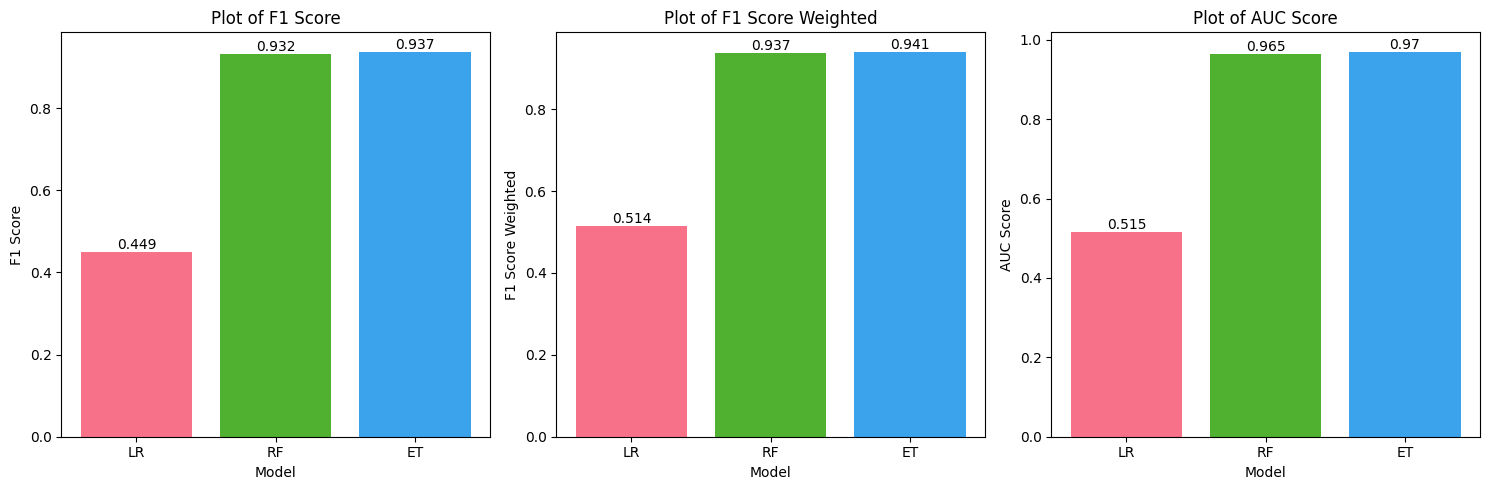

In [27]:
plot_bar_and_histogram(dataframe = result)

# SHAP ANALYSIS

In [8]:
df_check = data.copy()
y = df_check['readmitted']
X = df_check.drop(columns='readmitted')
X = X.fillna(X.mean())
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

0         0
1         0
2         0
3         0
4         0
         ..
180813    1
180814    1
180815    1
180816    1
180817    1
Name: readmitted, Length: 180818, dtype: int64

In [11]:
X['target'] = y

In [12]:
X_sample = X.sample(frac=0.01, random_state=42)  # Adjust random_state for different random samples

In [17]:
X['target'].value_counts()

target
0    90409
1    90409
Name: count, dtype: int64

In [18]:
X_sample.target.value_counts()

target
1    933
0    875
Name: count, dtype: int64

In [19]:
yy = X_sample['target']
XX = X_sample.drop(columns='target')

In [20]:
##Redundant Features
cols = ['id', 'encounter_id', 'patient_nbr','payer_code', 'admission_type_id','discharge_disposition_id','admission_source_id']
XX = XX.drop(columns = cols)

In [21]:
import shap
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [22]:
shap.initjs()

In [23]:
model = RandomForestClassifier()

In [26]:
model.fit(XX, yy)

RandomForestClassifier()

In [27]:
explainer = shap.TreeExplainer(model)

In [28]:
shap_values = explainer.shap_values(XX)

In [29]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0, :], XX.iloc[0, :])

In [54]:
shap.force_plot(explainer.expected_value[1], shap_values[1][150, :], XX.iloc[150, :])

In [55]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1500, :], XX.iloc[1500, :])

In [66]:
shap.force_plot(explainer.expected_value[1], shap_values[1][450, :], XX.iloc[450, :])

In [30]:
shap.force_plot(
    explainer.expected_value[1], shap_values[1][:1000, :], XX.iloc[:1000, :]
)

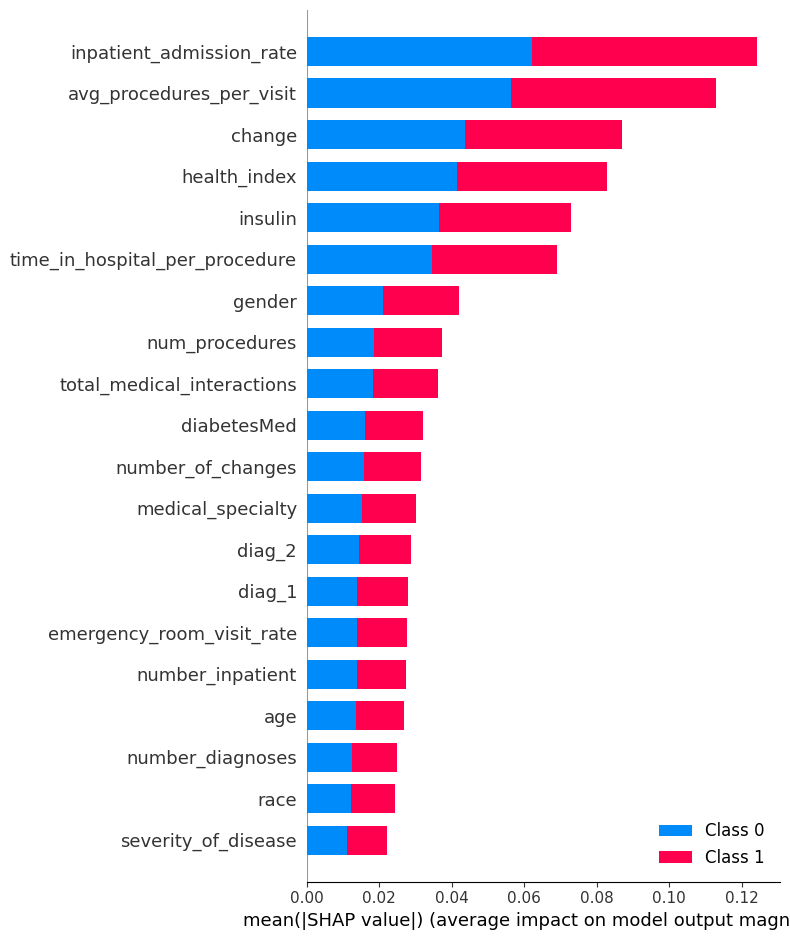

<Figure size 640x480 with 0 Axes>

In [68]:
#shap.summary_plot(shap_values, XX)
shap.summary_plot(shap_values, XX, plot_type='bar')
plt.savefig('shap_summary_plot.png')

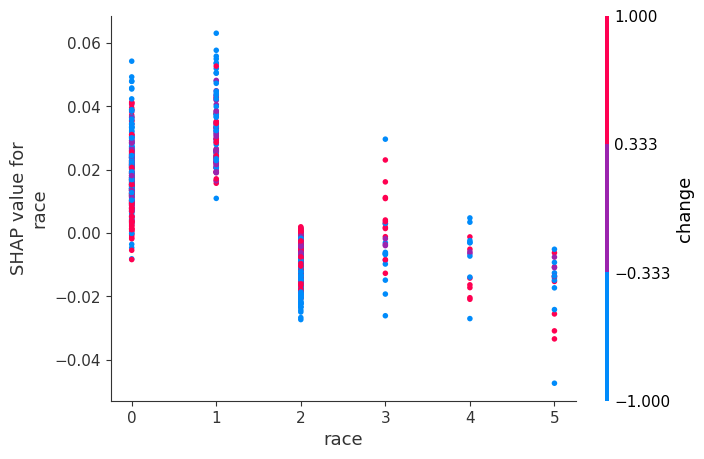

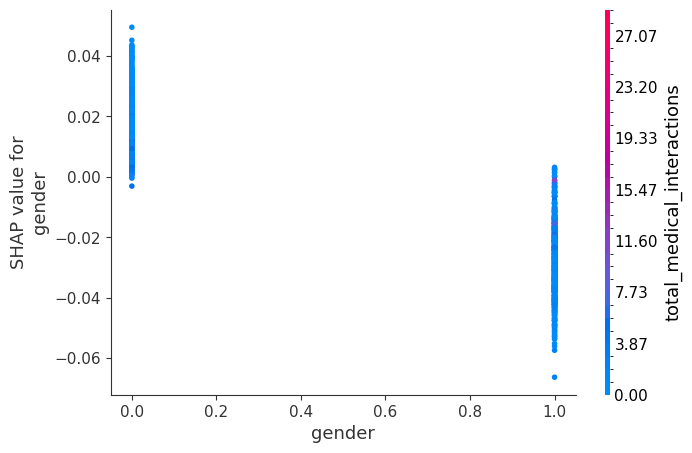

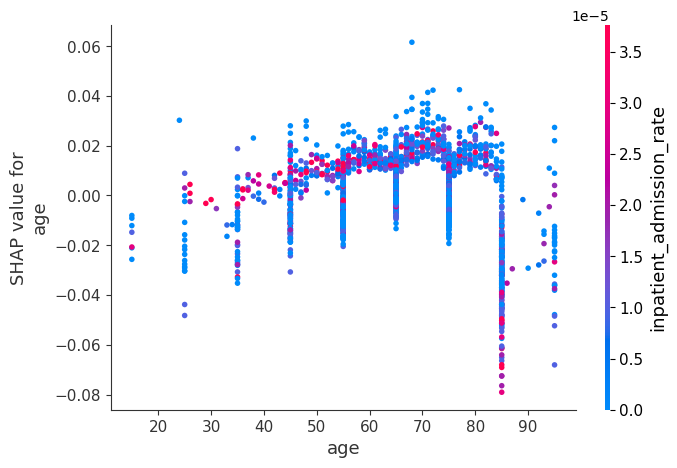

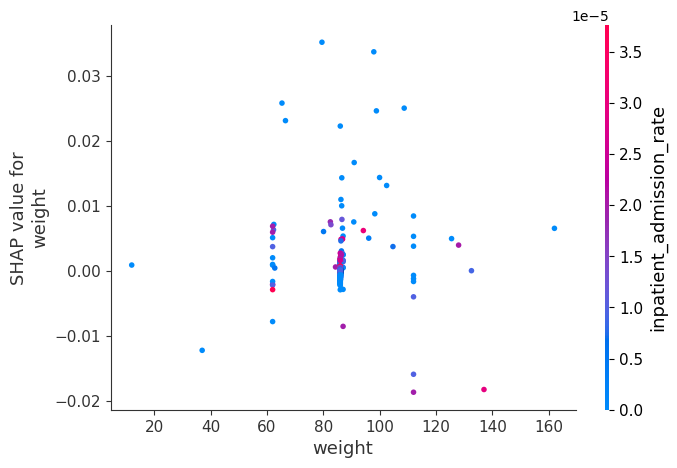

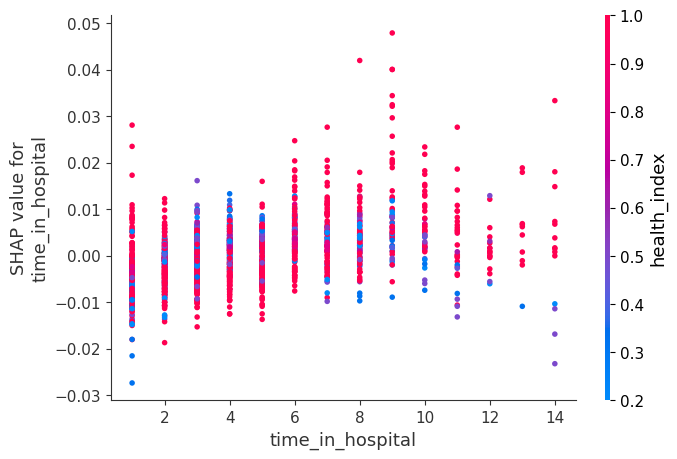

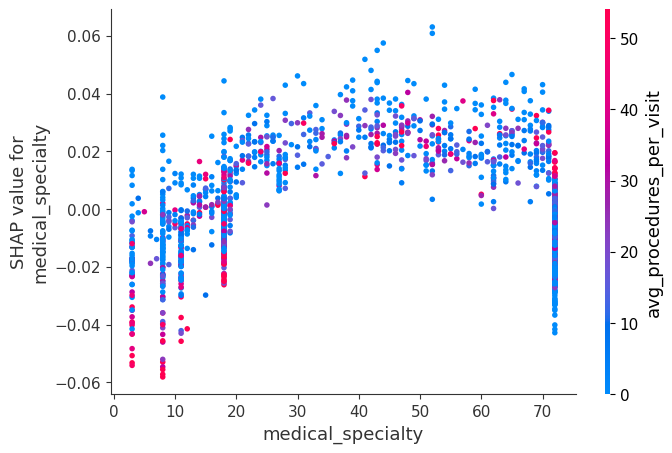

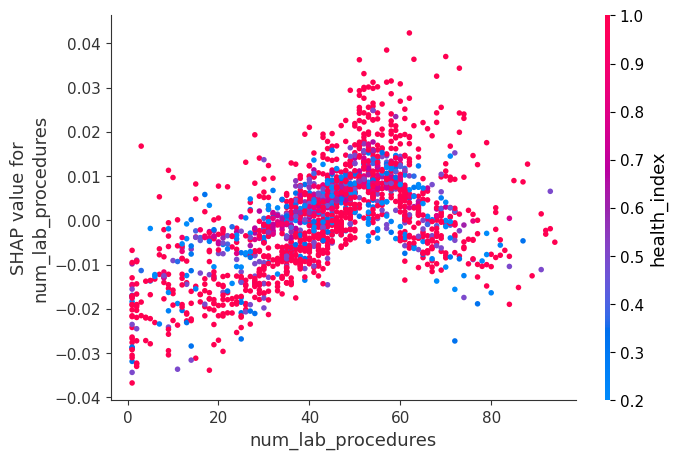

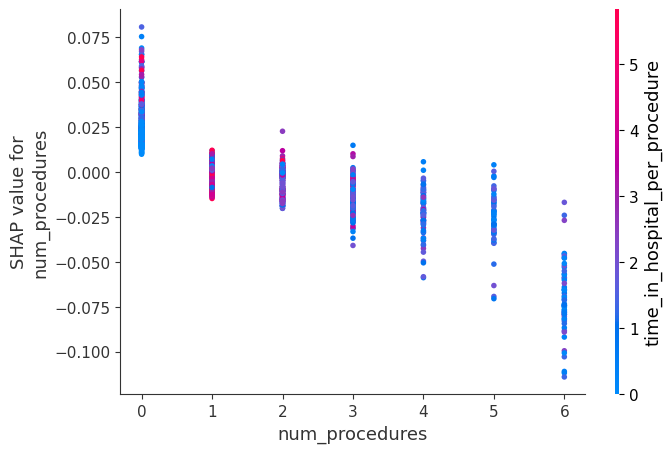

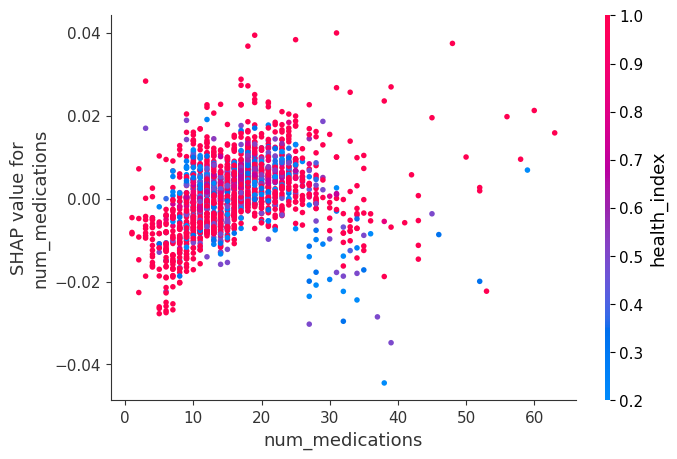

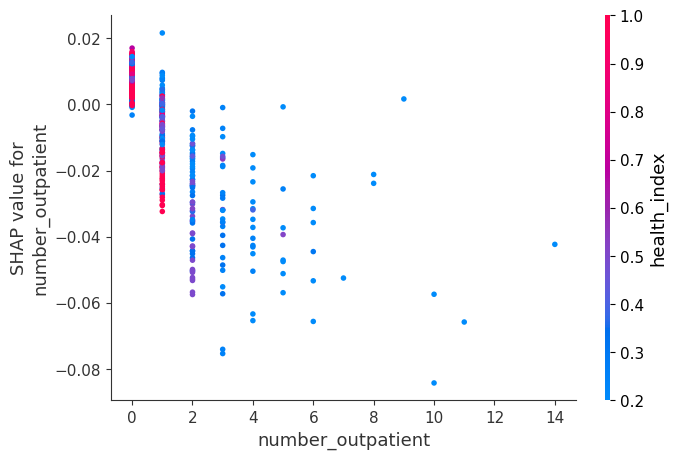

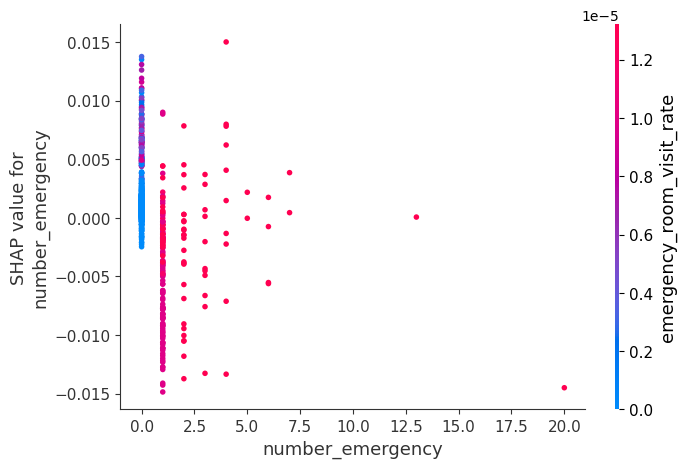

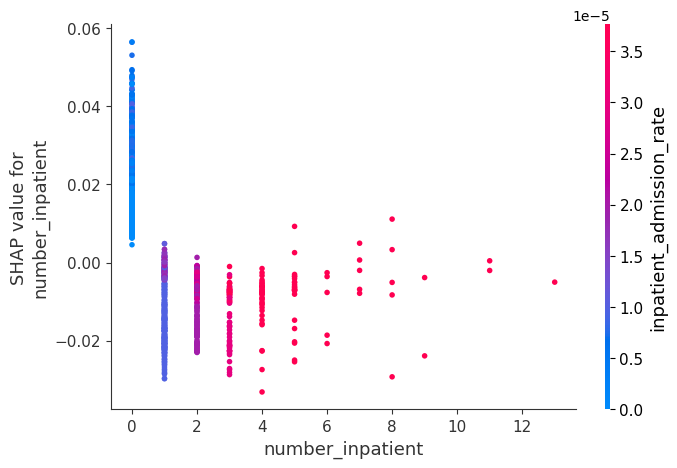

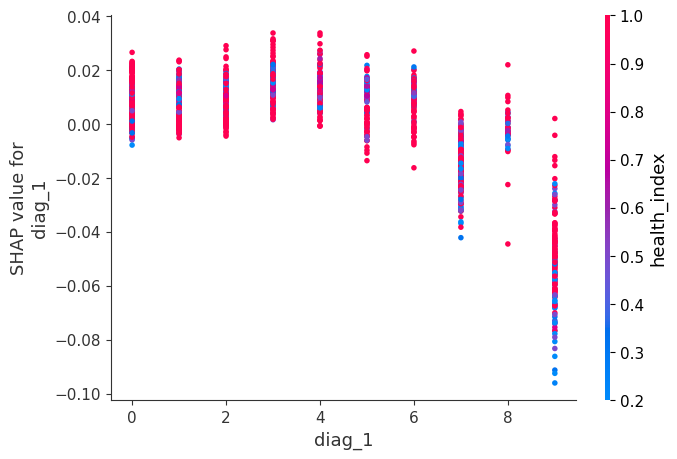

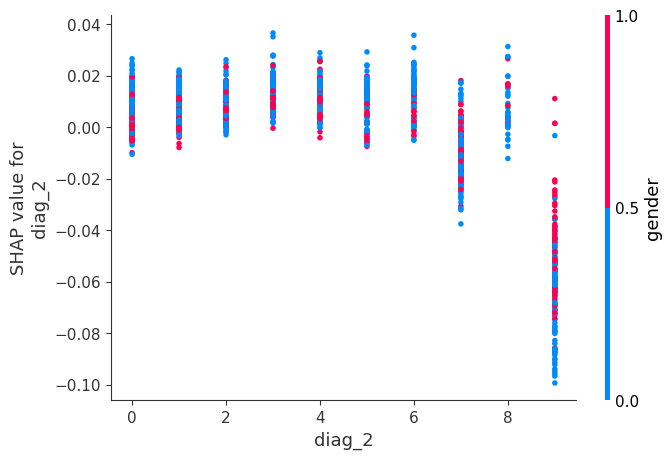

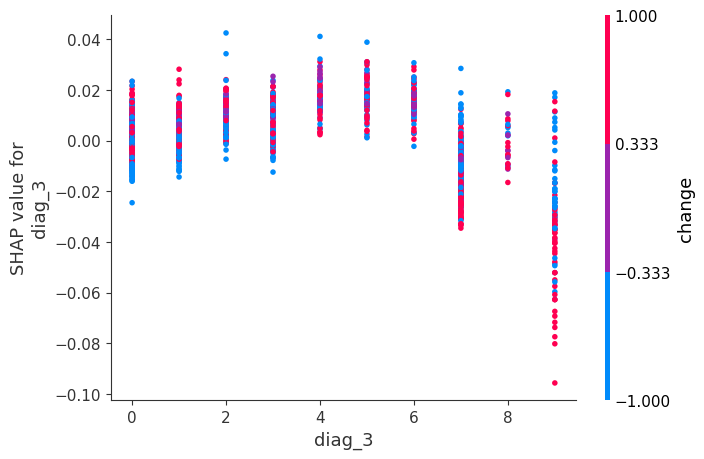

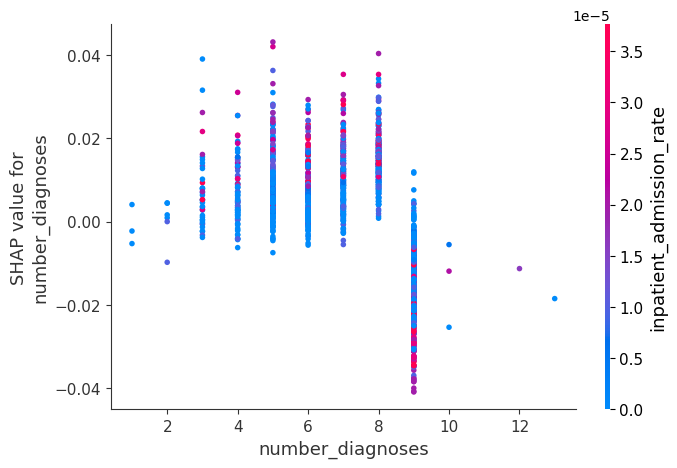

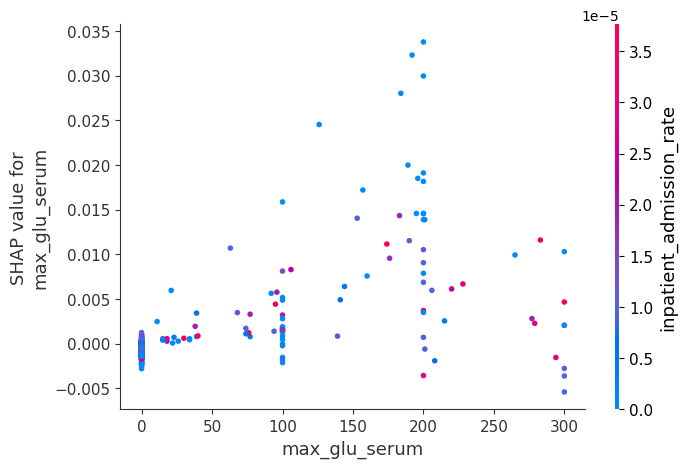

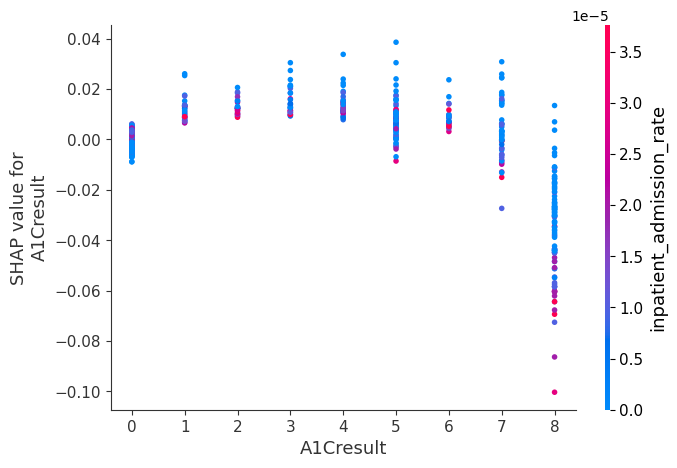

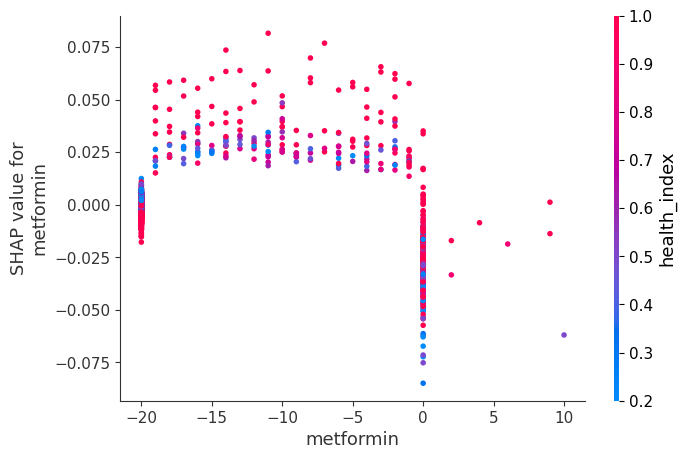

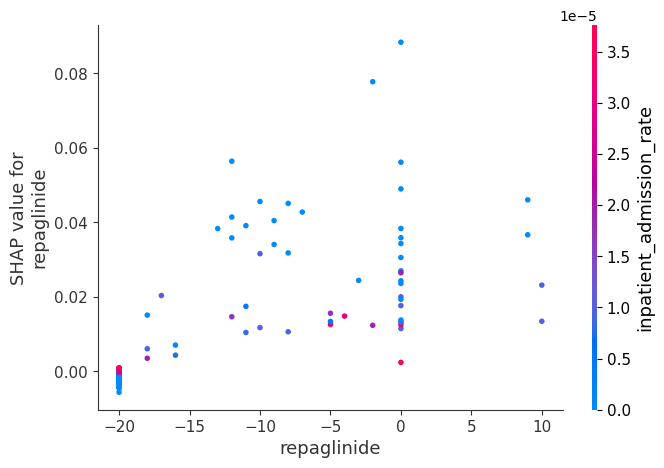

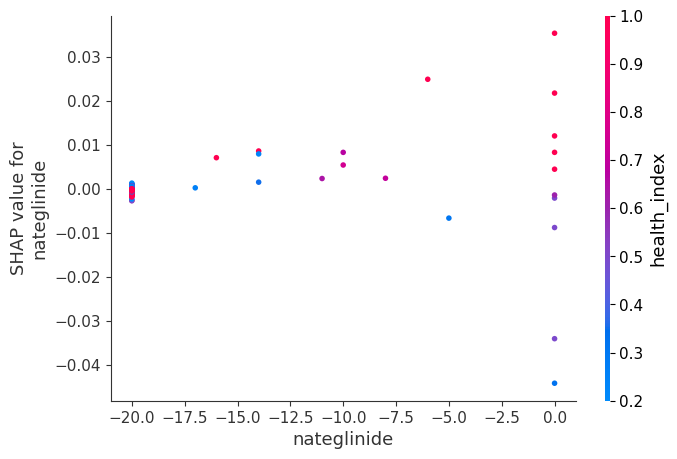

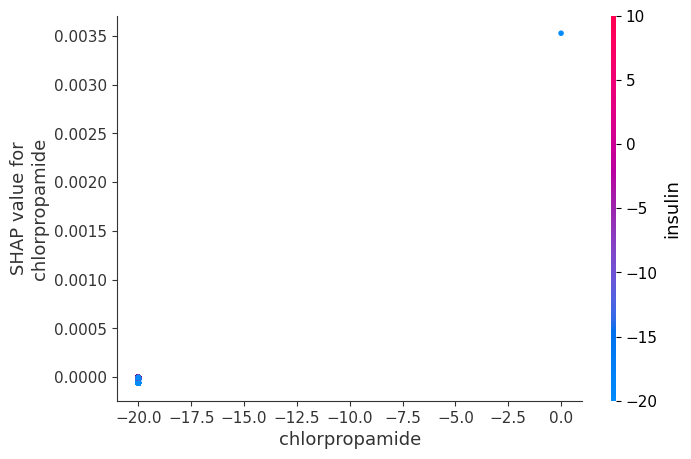

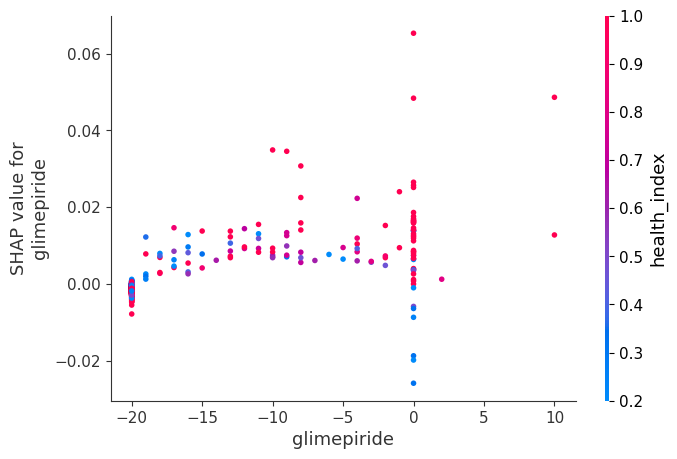

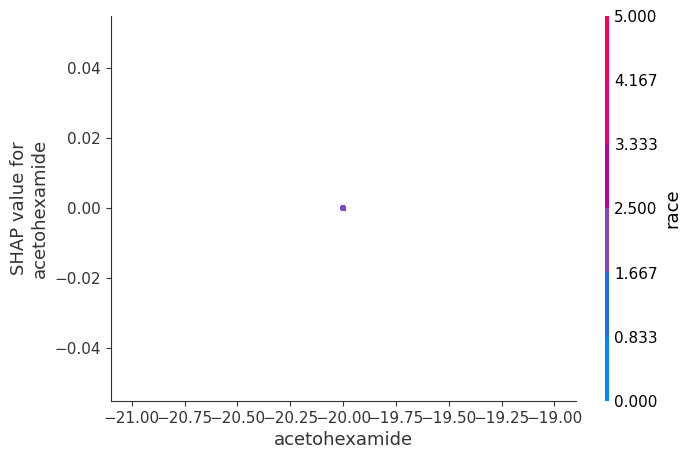

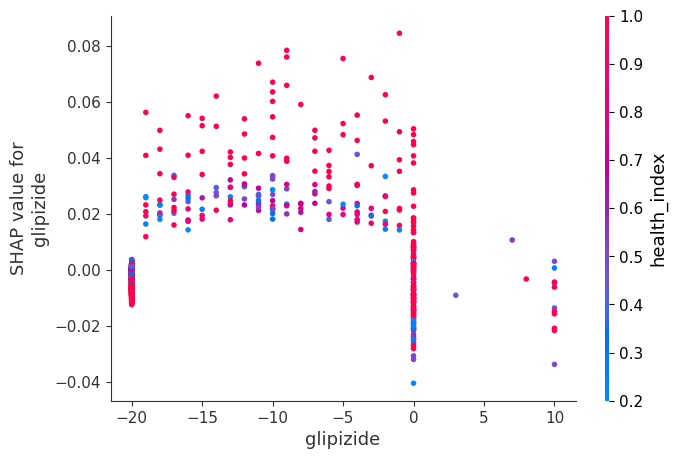

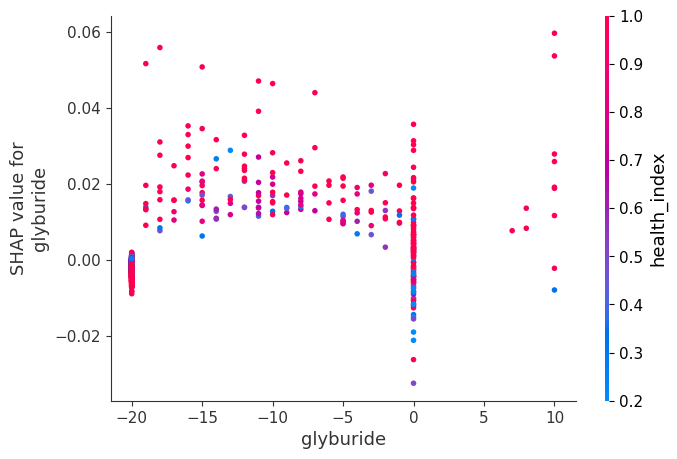

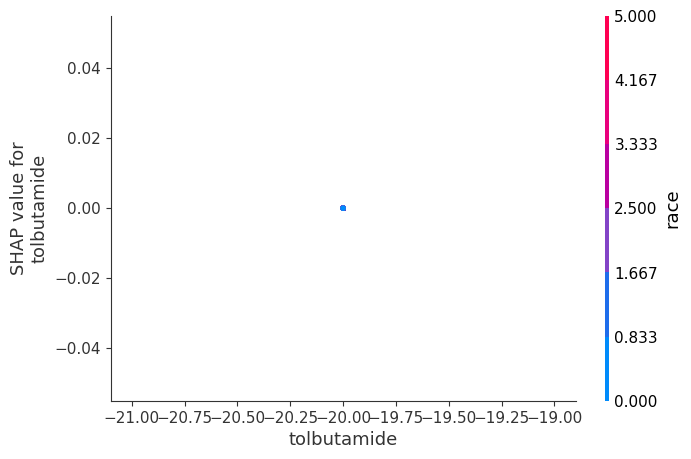

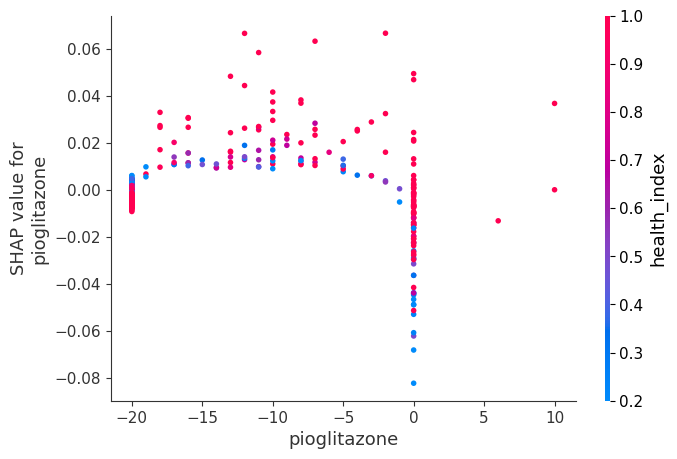

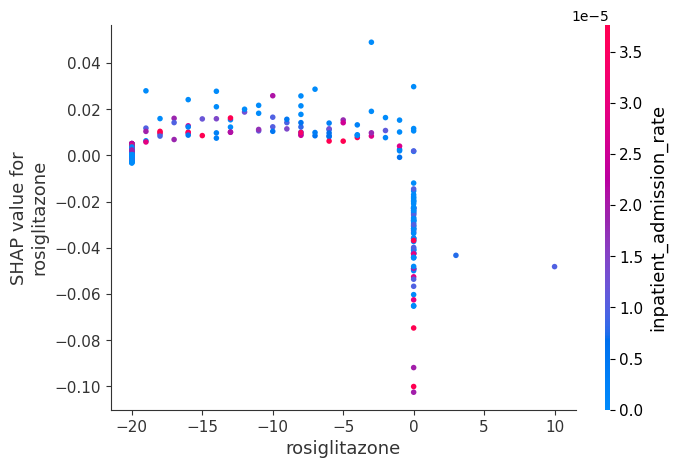

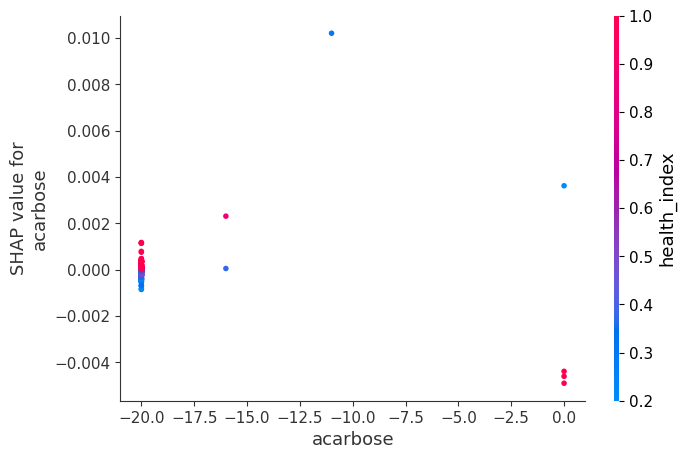

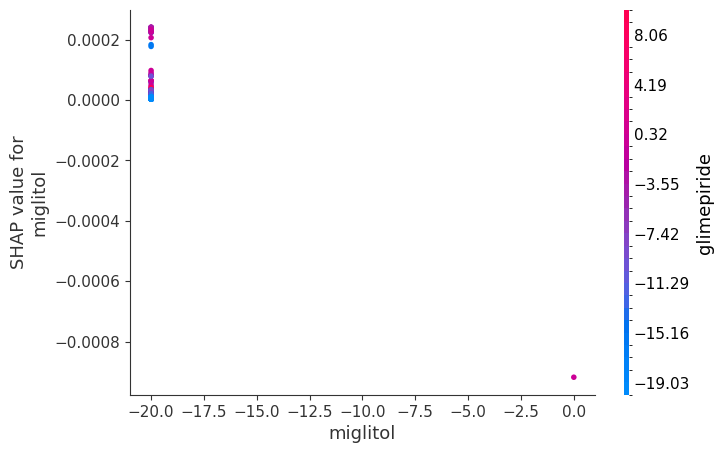

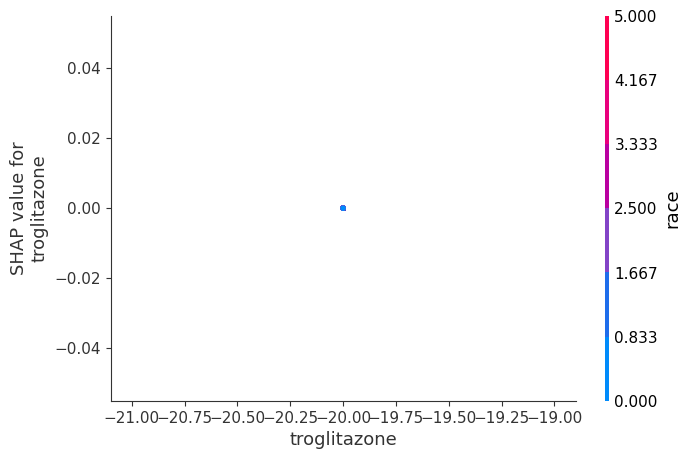

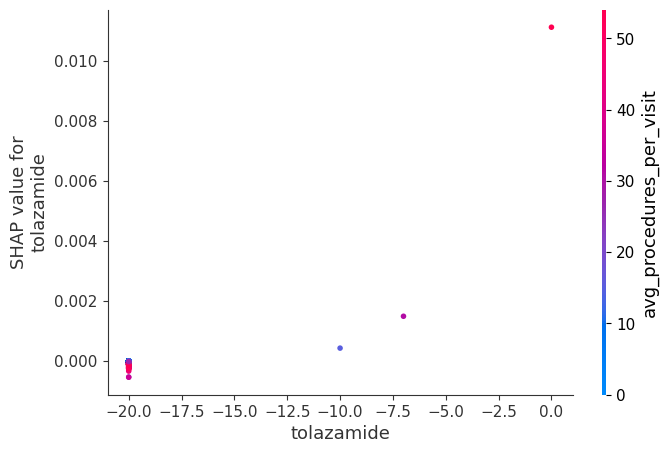

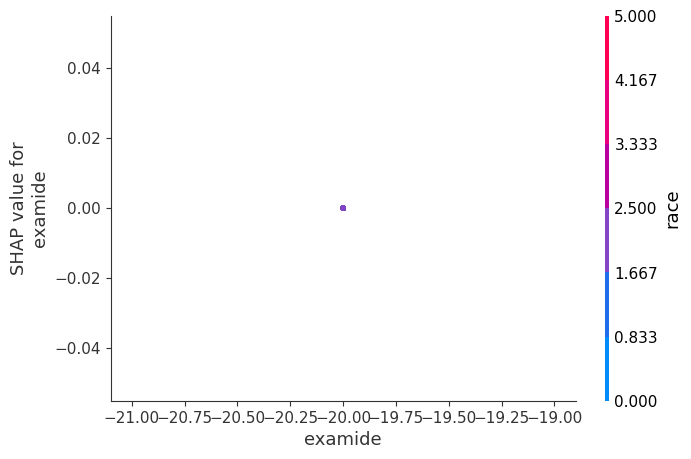

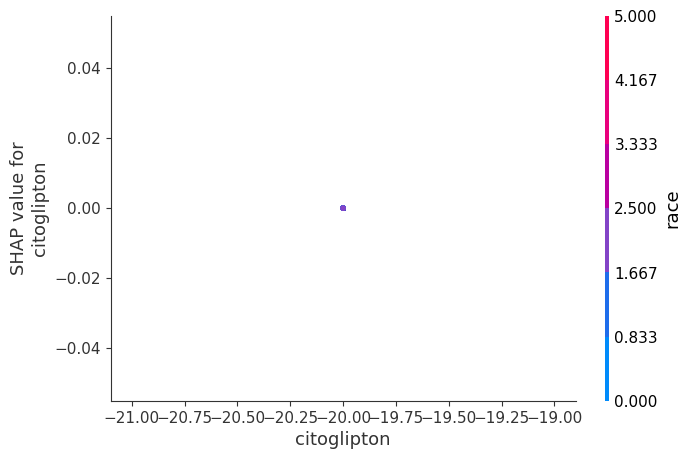

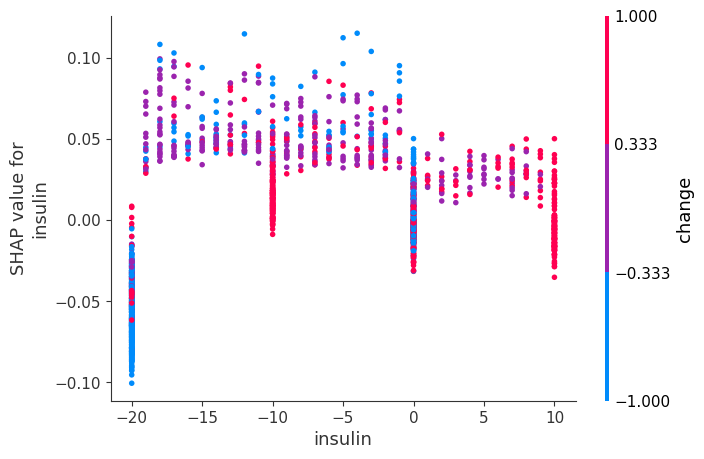

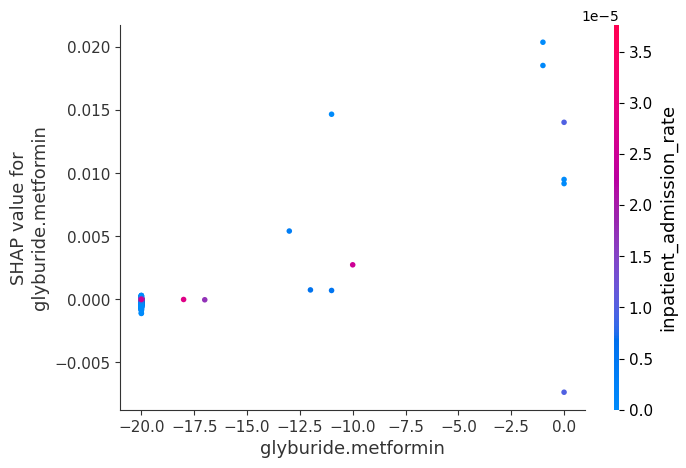

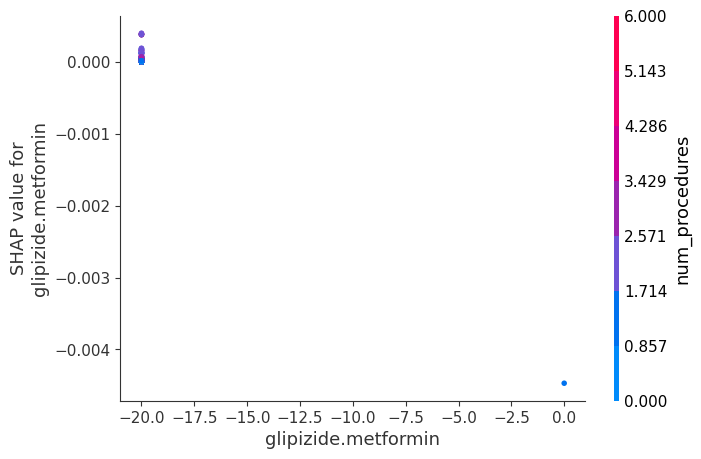

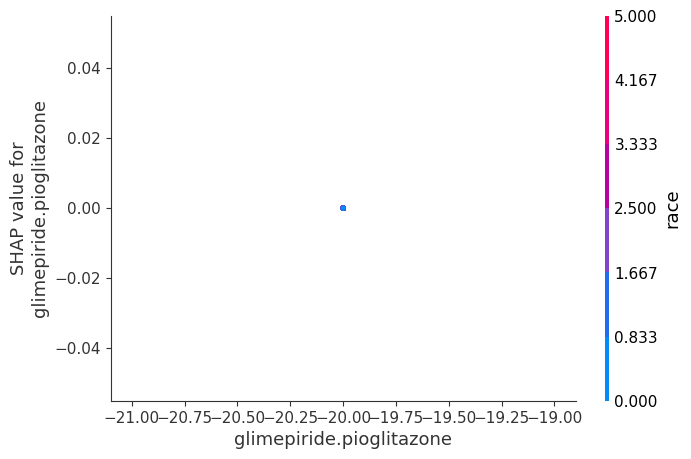

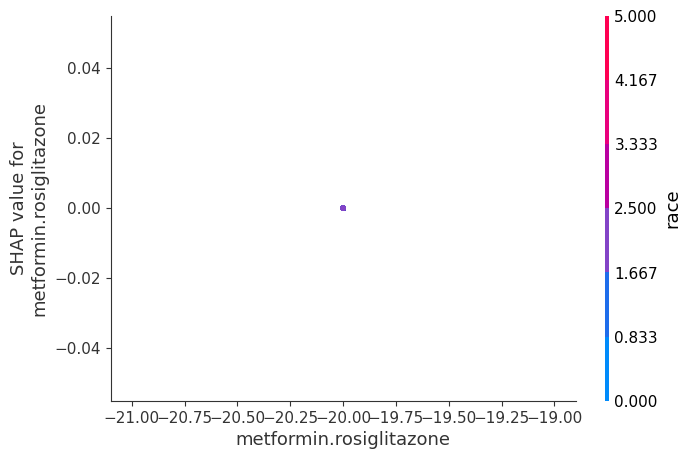

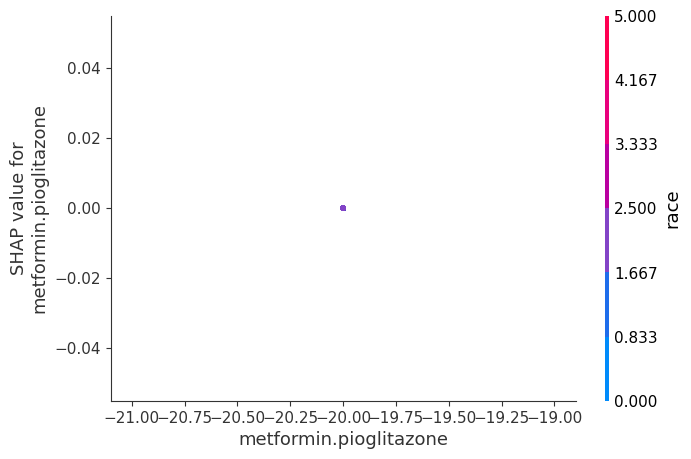

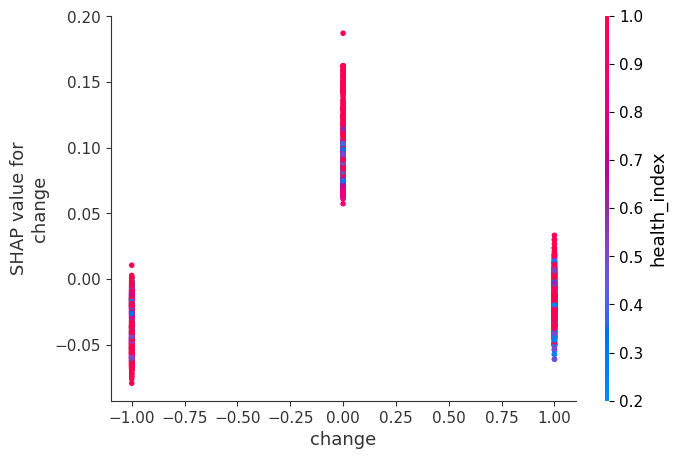

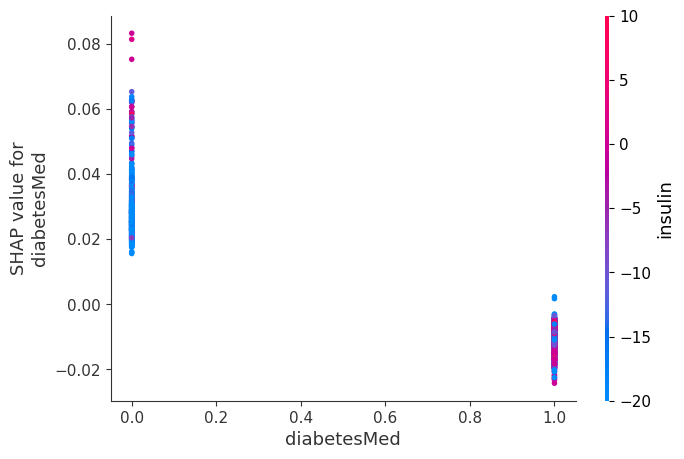

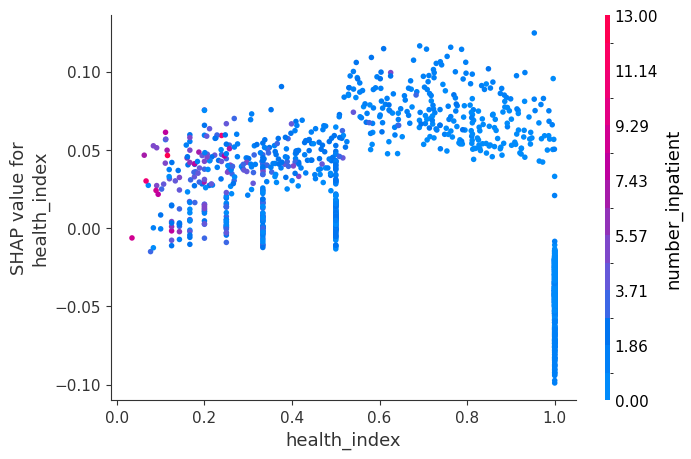

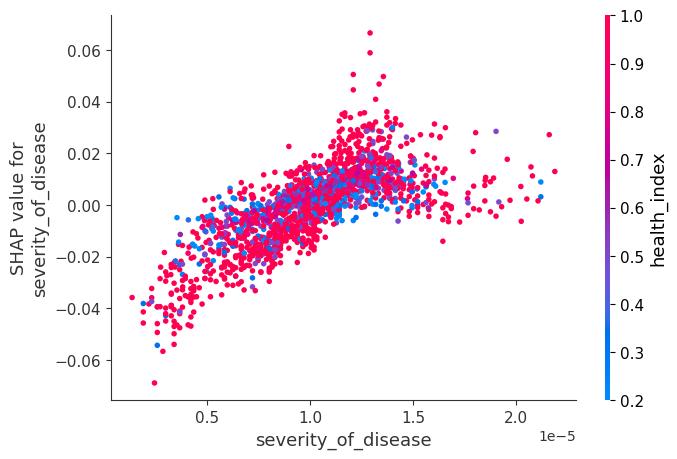

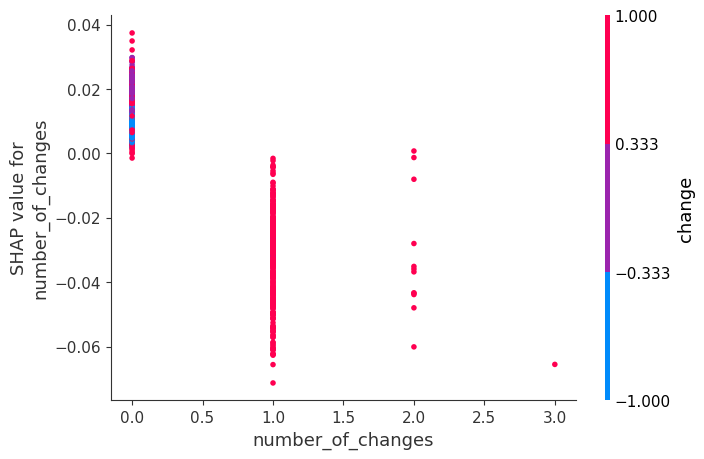

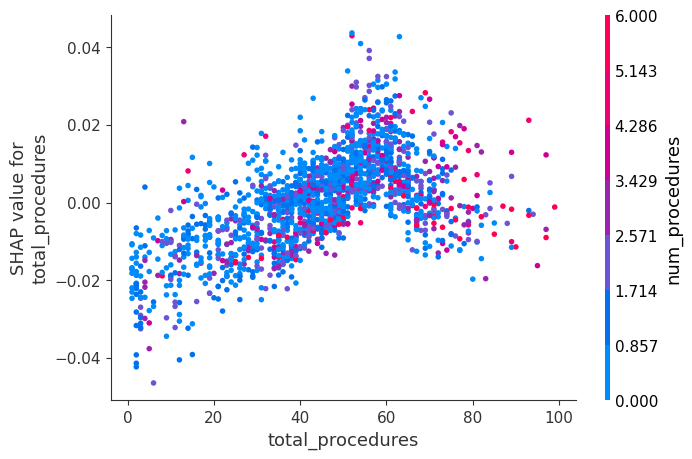

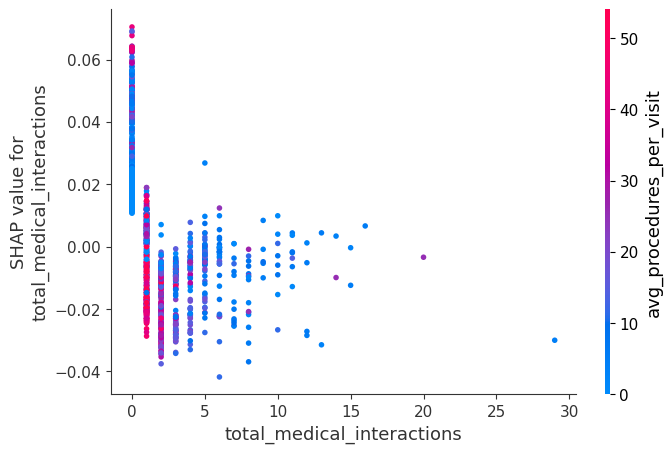

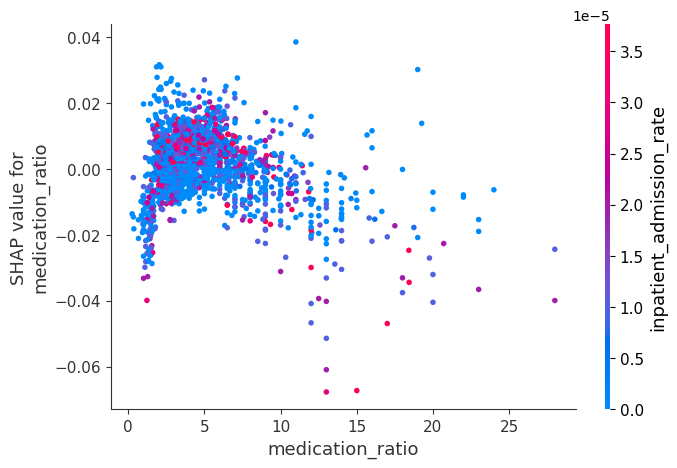

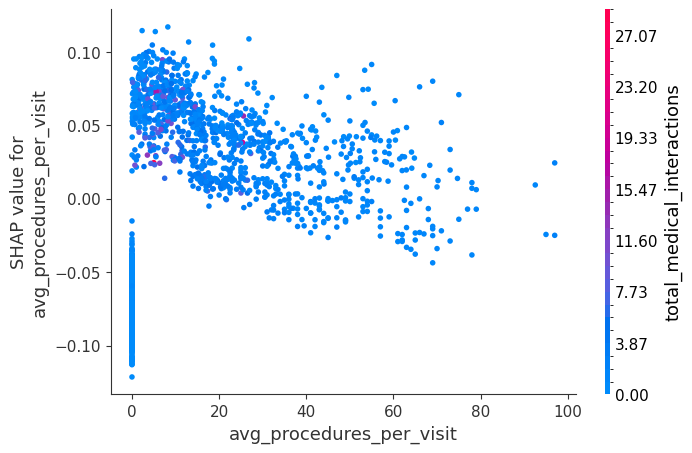

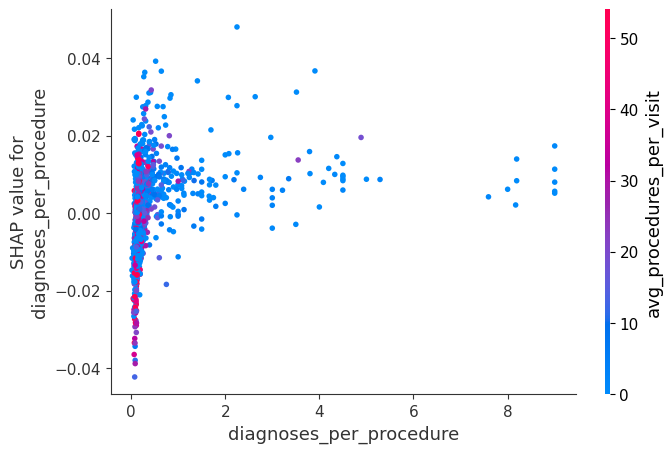

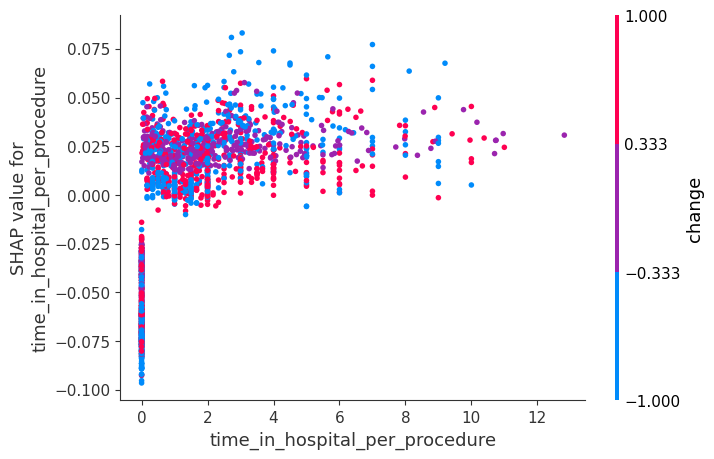

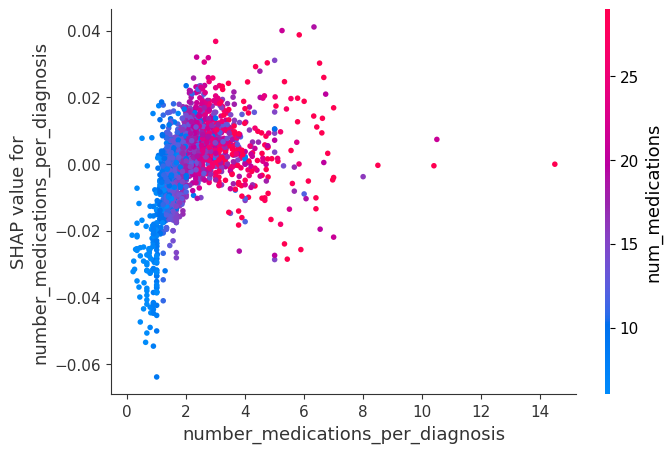

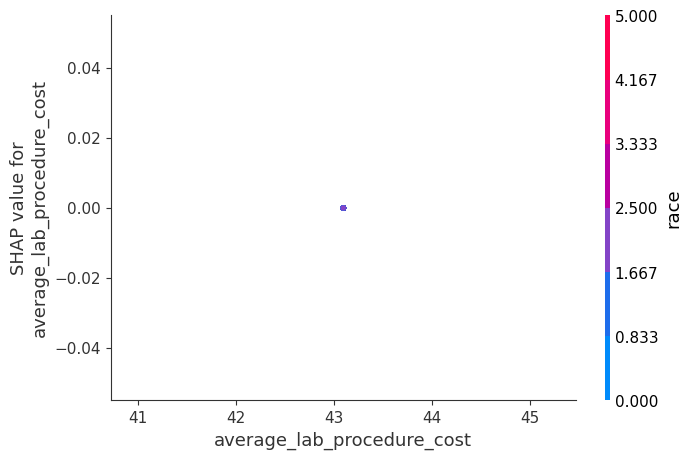

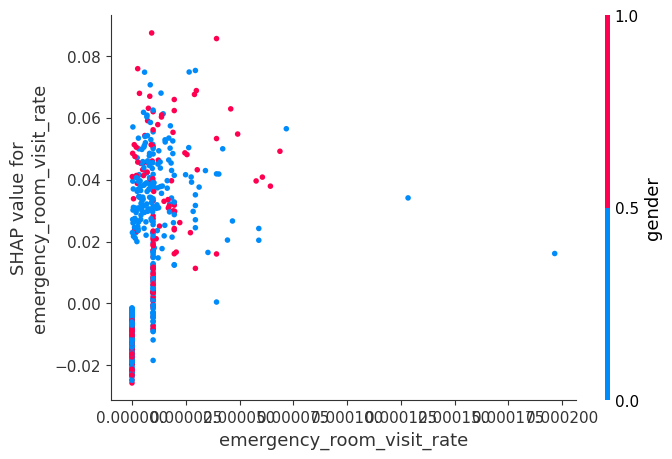

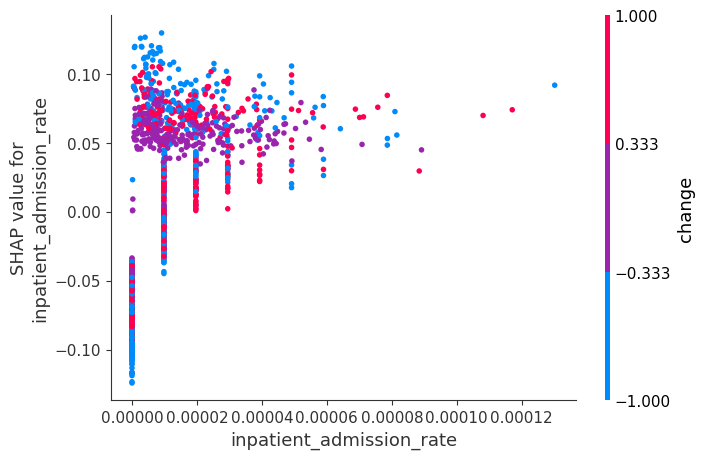

In [33]:
for name in XX.columns:
    shap.dependence_plot(name, shap_values[1], XX, display_features=XX)
